In [1]:
from datetime import date, datetime
import pandas as pd
import plotly.offline as offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.graph_objs as go
offline.init_notebook_mode(connected=True)
pd.set_option('display.max_rows', 10)

import numpy as np
import seaborn as sns
import panel as pn
import os
from pathlib import Path
from dotenv import load_dotenv

pn.extension('plotly')

import hvplot.pandas
# import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/Users/samuelwytenburg/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#import climate data
climate_df = pd.read_csv('data/raw_climate_data.csv')

#drop index column
climate_df = climate_df.drop(climate_df.columns[0], axis = 1)
#convert date column to datetime
climate_df['Date'] = pd.to_datetime(climate_df['Date'])

#set date to index
climate_df = climate_df.set_index(['Date'])

climate_df.head()

#pull out only pm10 data
pm_10 = climate_df[climate_df['Specie']=='co']




climate_df['Specie'].unique()

array(['no2', 'humidity', 'wind speed', 'pressure', 'so2', 'pm25', 'o3',
       'dew', 'temperature', 'wind-speed', 'wind-gust', 'co', 'pm10',
       'wind gust', 'wd', 'precipitation', 'aqi', 'pol', 'neph'],
      dtype=object)

In [3]:
#create dataframe for each country

india = pm_10[pm_10['Country']=='IN']['median'].pct_change()
china = pm_10[pm_10['Country']=='CN']['median'].pct_change()
united_kingdom = pm_10[pm_10['Country']=='GB']['median'].pct_change()
unitied_states = pm_10[pm_10['Country']=='US']['median'].pct_change()
australia = pm_10[pm_10['Country']=='AU']['median'].pct_change()
japan = pm_10[pm_10['Country']=='JP']['median'].pct_change()

# shenzen = china[china['City']=='Shenzhen']['median'].pct_change()
# shenzen['median'].plot()

# india.head()

In [4]:
start_date = int(datetime(2019, 1, 1, 0, 0).timestamp())
end_date = int(datetime(2020, 1, 1, 0, 0).timestamp())


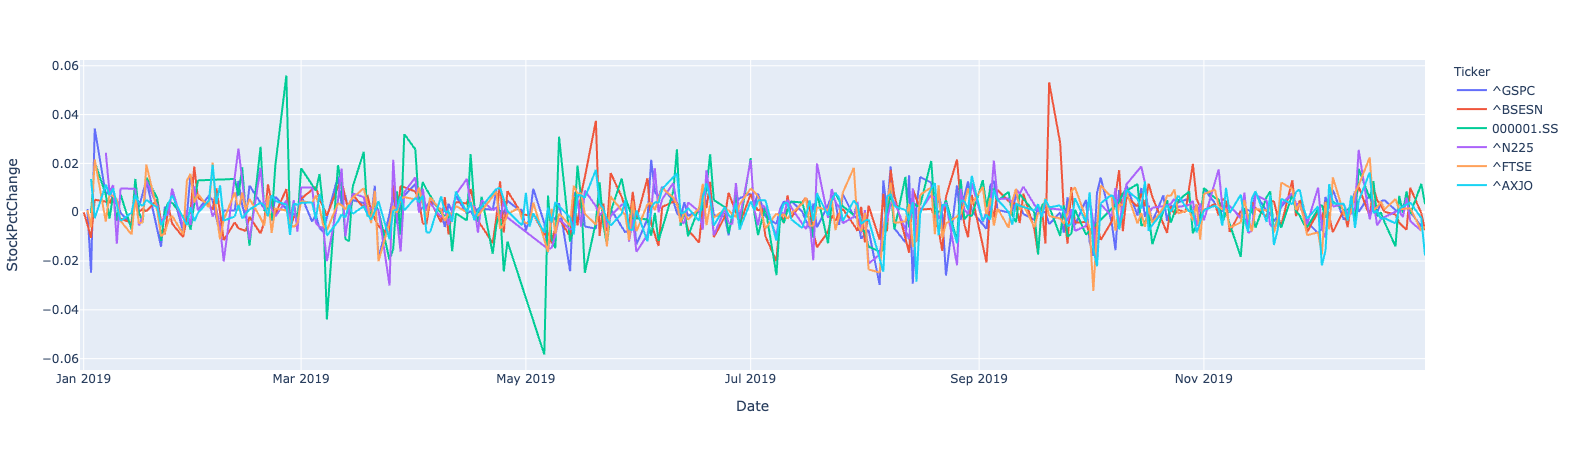

In [5]:
# yahoo url template (daily data: 2020-07-24 to 2020-11-25)
yahoo_url = 'https://query1.finance.yahoo.com/v7/finance/download/{tix}?period1={s}&period2={e}&interval=1d&events=history'
# get data for 3 tickers and concatenate together
tickers = ['^GSPC', '^BSESN','000001.SS', '^N225', '^FTSE', '^AXJO']
df = pd.DataFrame()
for ticker in tickers:
    url = yahoo_url.format(tix=ticker,s=start_date,e=end_date)
    df_tmp = pd.read_csv(url)
    df_tmp['Ticker'] = ticker
    df_tmp['StockPctChange'] = df_tmp['Close'].pct_change()
    df = pd.concat([df, df_tmp])
df.to_csv('data/stock_2019.csv')
fig = px.line(df, x="Date", y="StockPctChange", color='Ticker')
fig.show()


In [6]:
start_date = int(datetime(2020, 1, 1, 0, 0).timestamp())
end_date = int(datetime(2021, 1, 1, 0, 0).timestamp())
# yahoo url template (daily data: 2020-07-24 to 2020-11-25)
yahoo_url = 'https://query1.finance.yahoo.com/v7/finance/download/{tix}?period1={s}&period2={e}&interval=1d&events=history'
# get data for 3 tickers and concatenate together
tickers = ['^GSPC', '^BSESN','000001.SS', '^N225', '^FTSE', '^AXJO']
df = pd.DataFrame()
for ticker in tickers:
    url = yahoo_url.format(tix=ticker,s=start_date,e=end_date)
    df_tmp = pd.read_csv(url)
    df_tmp['Ticker'] = ticker
    df_tmp['StockPctChange'] = df_tmp['Close'].pct_change()
    df = pd.concat([df, df_tmp])
df.to_csv('data/stock_2020.csv')

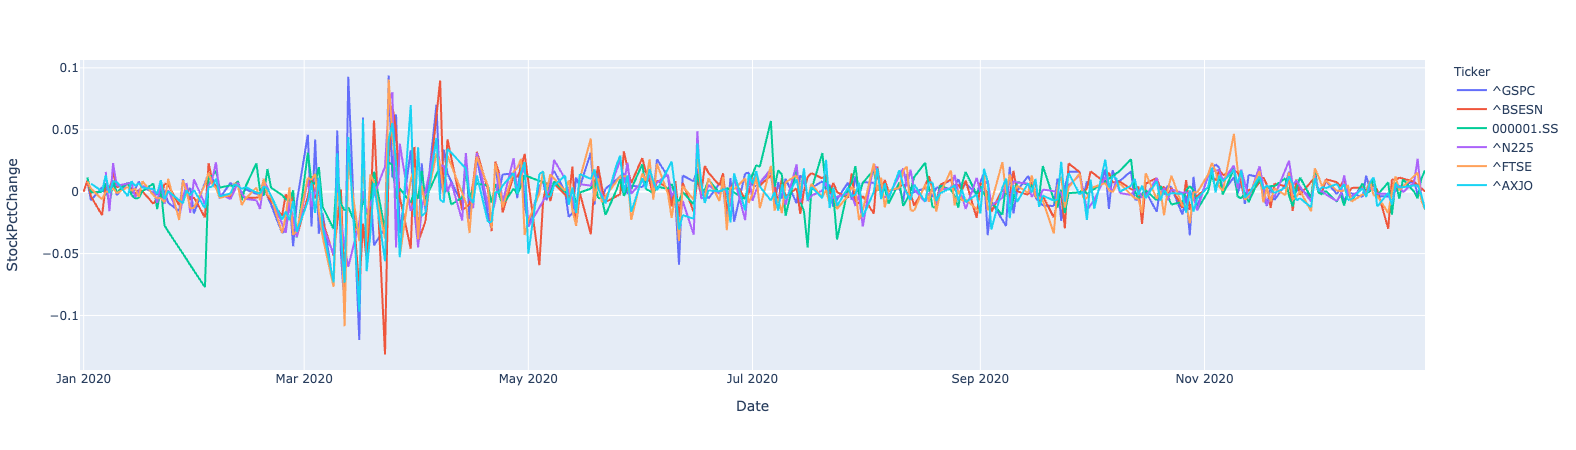

In [7]:
fig = px.line(df, x="Date", y="StockPctChange", color='Ticker')
fig.show()

In [37]:
# fig = px.line(df_india_concat)
# fig.show()
climate_df.head()

Country      City Specie  count  min    max  median  variance
Date                                                                    
2020-01-06      IN  Thrissur    no2     24  3.1    3.7     3.4      0.14
2020-03-20      IN  Thrissur    no2     24  4.4    6.0     5.1      2.35
2020-04-05      IN  Thrissur    no2     46  0.1    2.6     2.2      9.80
2020-05-31      IN  Thrissur    no2     48  1.7  113.2     9.2   6269.02
2020-06-15      IN  Thrissur    no2     39  1.7    2.5     1.8      1.09

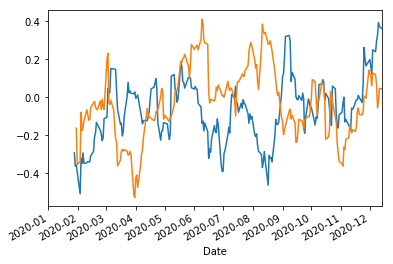

In [44]:
country_dict = {'IN' : '^BSESN',
                'CN' : '000001.SS',
                'JP' : '^N225',
                'AU' : '^AXJO',
                'GB' : '^FTSE',
                'US' : '^GSPC'}




def corr_graph_maker(country='IN', polutant='co'):
    polutant_df = climate_df[climate_df['Specie'] == polutant]
    
    polutant_df_country = polutant_df[polutant_df['Country']== country]['median'].groupby('Date').mean().pct_change()
    df_stock = df[df['Ticker'] == country_dict[country]].set_index('Date')


    df_stock.index = df_stock.index.astype('datetime64[ns]')
    df_stock_polutants = pd.DataFrame({'Date':polutant_df_country.index, 'PolutantPctChange':polutant_df_country.values})
    df_stock_polutants.set_index('Date', inplace=True)
    df_stock_polutants = df_stock_polutants[~df_stock_polutants.index.duplicated(keep='first')]   
    
    df_stock_concat = pd.concat([df_stock, df_stock_polutants], join='inner', axis=1)
    # df_stock_concat = df_stock_concat[['StockPctChange', 'PolutantPctChange']]

    corrSeries = df_stock_concat['StockPctChange'].rolling(20).corr(df_stock_concat['PolutantPctChange'])
    corrDf = pd.DataFrame({'Date':corrSeries.index, 'corr':corrSeries.values})
#     corrDf.columns = ['Date', 'Corr']
    # print(corr)
    bx = corrSeries.plot()
#     print(corrSeries.tail())
#     bx = px.scatter_matrix(corrDf , color='PolutantPctChange')
    return bx
corr_graph_maker()
corr_graph_maker('US')

In [10]:
def corr_graph_maker_2(country='IN'):
    #co df
    polutant_df1 = climate_df[climate_df['Specie'] == 'co']
    polutant_df_country1 = polutant_df1[polutant_df1['Country']== country]['median'].pct_change()
    #so2 df
    polutant_df2 = climate_df[climate_df['Specie'] == 'so2']
    polutant_df_country2 = polutant_df2[polutant_df2['Country']== country]['median'].pct_change()
    #no2
    polutant_df3 = climate_df[climate_df['Specie'] == 'no2']
    polutant_df_country3 = polutant_df3[polutant_df3['Country']== country]['median'].pct_change()
    
    
    
    df_stock = df[df['Ticker'] == country_dict[country]].set_index('Date')


    df_stock.index = df_stock.index.astype('datetime64[ns]')
    df_stock_polutants = pd.DataFrame({'Date':polutant_df_country1.index, 'PolutantPctChange':polutant_df_country1.values})
    df_stock_polutants.set_index('Date', inplace=True)
    df_stock_polutants = df_stock_polutants[~df_stock_polutants.index.duplicated(keep='first')]   

    df_stock_polutants2 = pd.DataFrame({'Date':polutant_df_country2.index, 'PolutantPctChange':polutant_df_country2.values})
    df_stock_polutants2.set_index('Date', inplace=True)
    df_stock_polutants2 = df_stock_polutants2[~df_stock_polutants2.index.duplicated(keep='first')] 
    
    
    df_stock_concat = pd.concat([df_stock, df_stock_polutants,df_stock_polutants2], join='inner', axis=1)
    # df_stock_concat = df_stock_concat[['StockPctChange', 'PolutantPctChange']]

    corrSeries = df_stock_concat['StockPctChange'].rolling(20).corr(df_stock_concat['PolutantPctChange'].rolling(20))
    return corrSeries
#     corrDf = pd.DataFrame({'Date':corrSeries.index, 'PolutantPctChange':corrSeries.values})
#     corrDf.columns = ['Date', 'Corr']
#     # print(corr)
#     bx = px.scatter_matrix(corrDf , color='Corr')
    return bx

In [11]:
print(corr_graph_maker_2())


#population weight cities
# population of city / population of all cities in sample

            PolutantPctChange  PolutantPctChange
Date                                            
2019-12-31                NaN                NaN
2020-01-01                NaN                NaN
2020-01-02                NaN                NaN
2020-01-03                NaN                NaN
2020-01-06                NaN                NaN
...                       ...                ...
2020-12-08          -0.031741          -0.364258
2020-12-09          -0.120985          -0.303397
2020-12-10          -0.081035          -0.214510
2020-12-11          -0.075856          -0.235218
2020-12-14          -0.067798          -0.230894

[240 rows x 2 columns]


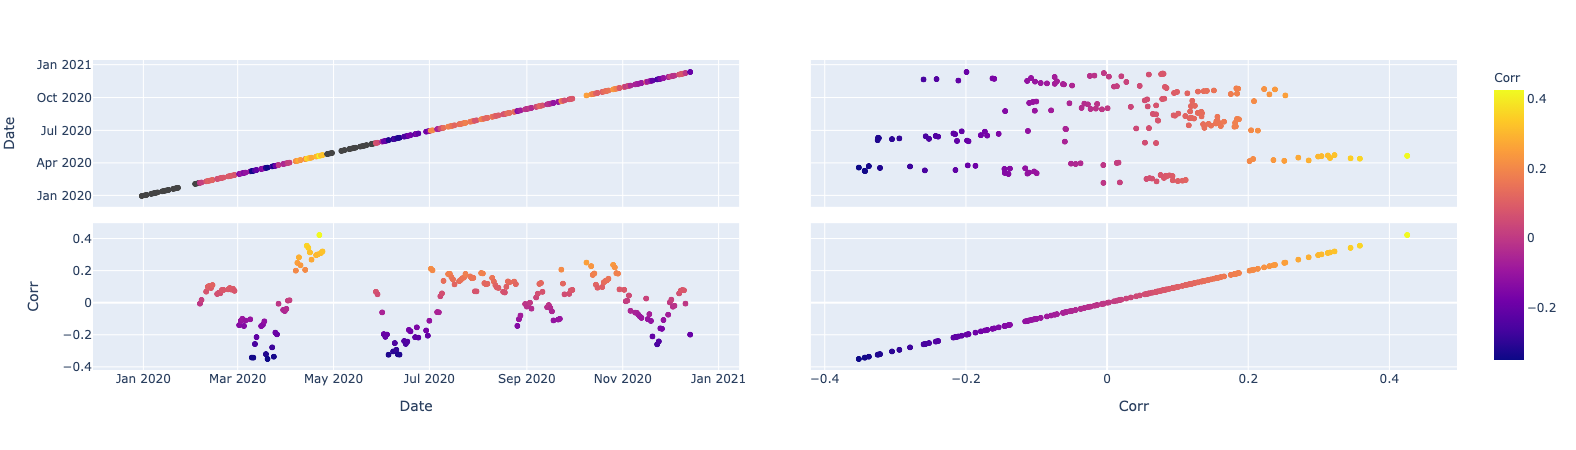

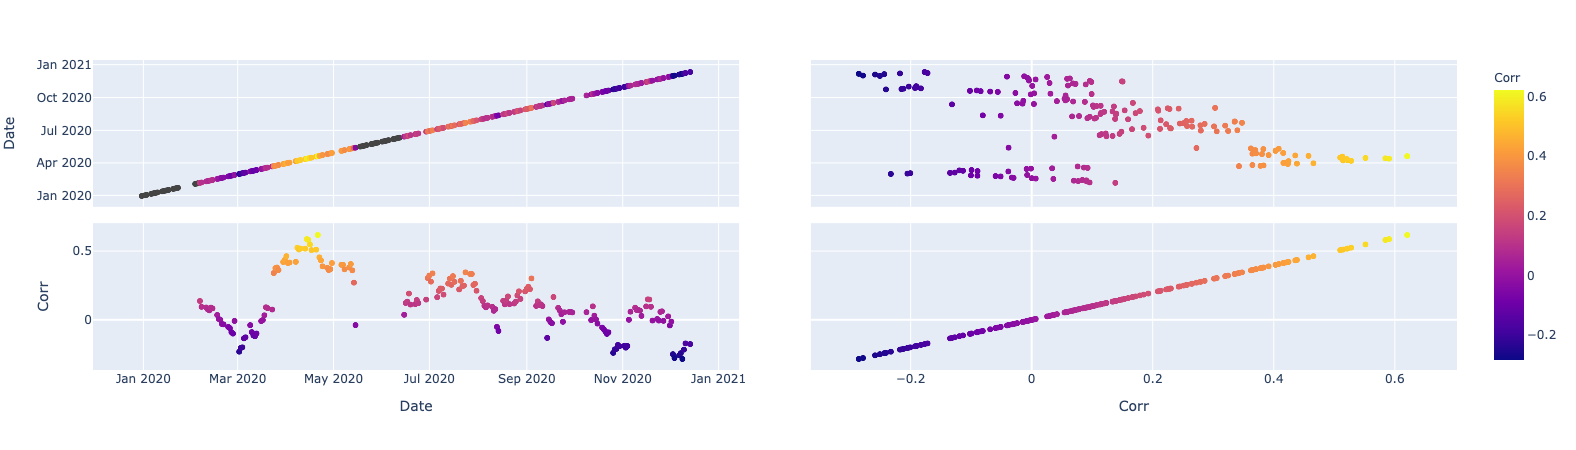

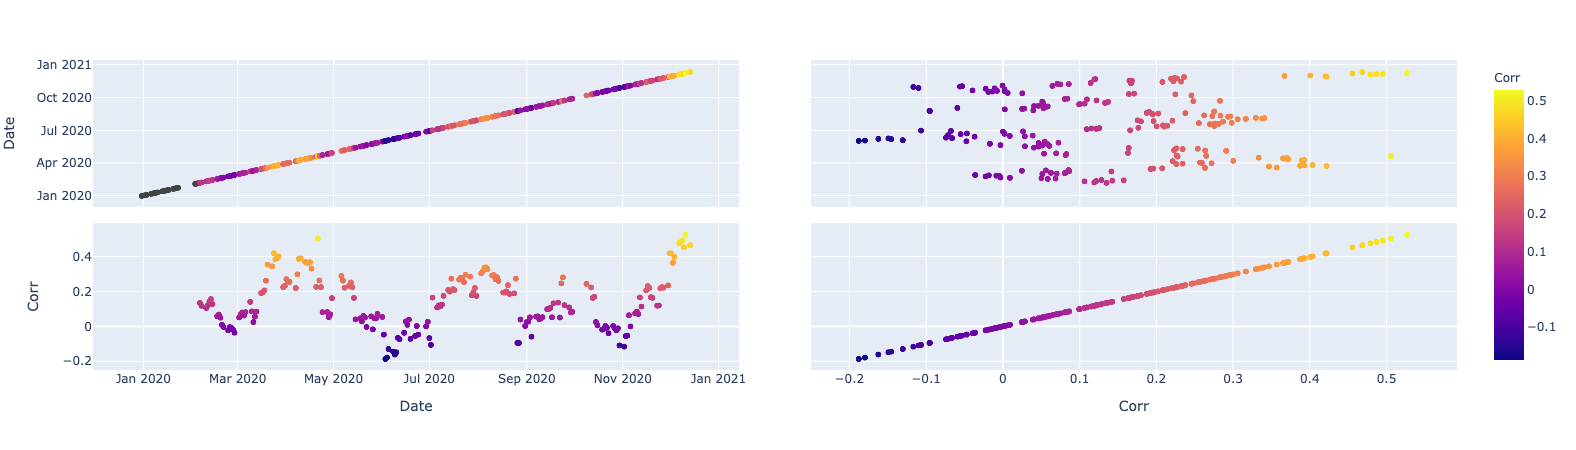

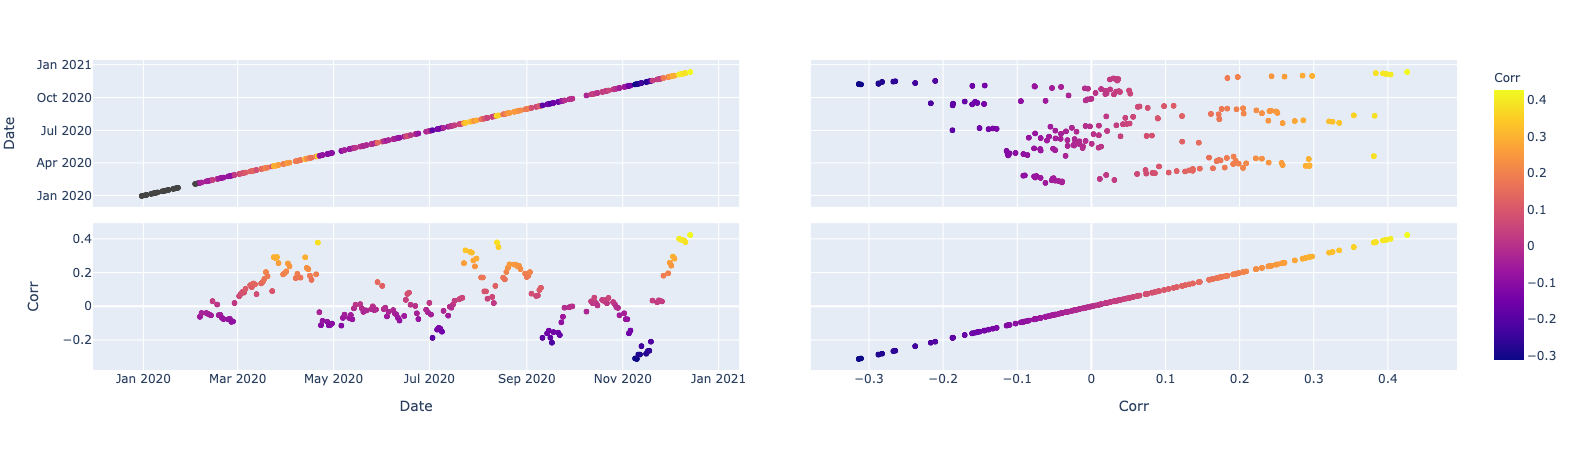

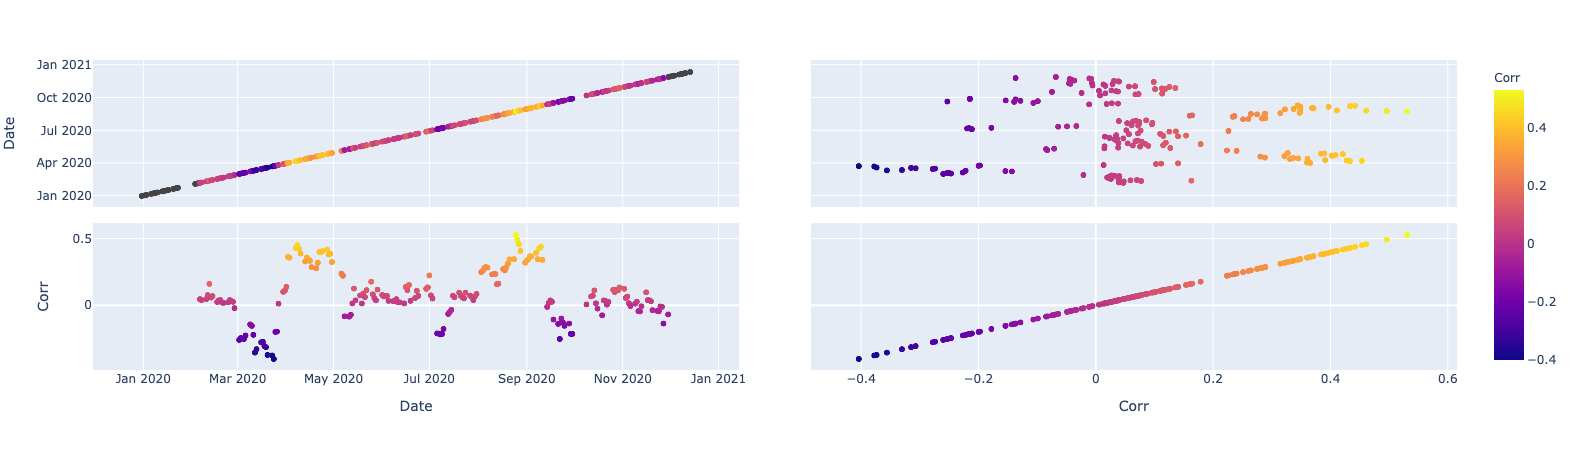

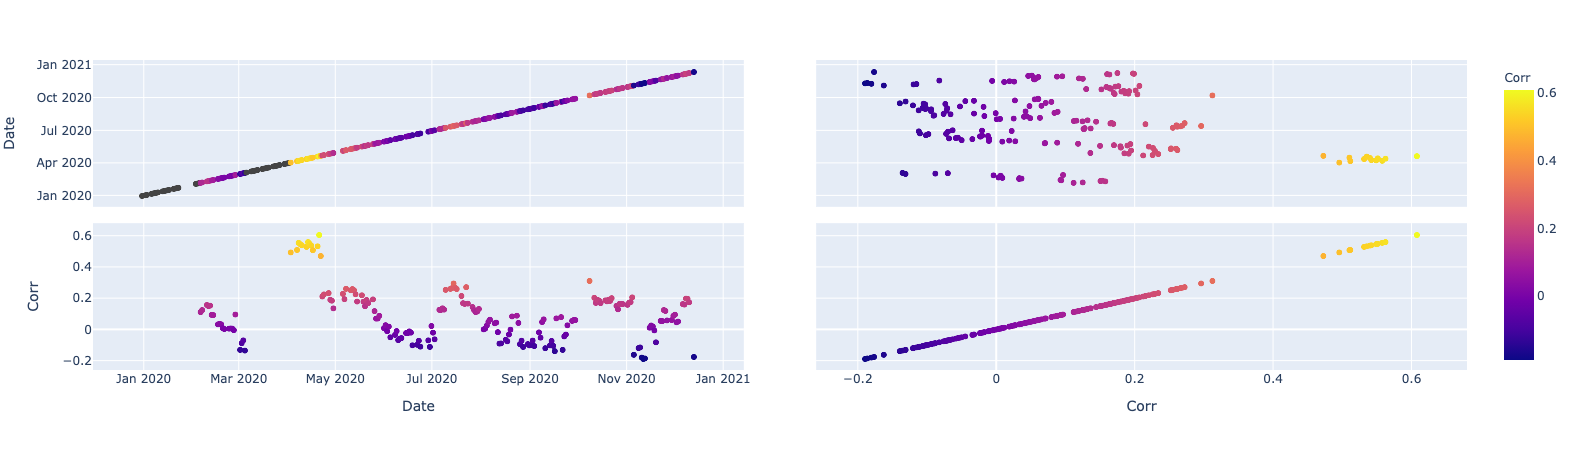

In [15]:
fig1 = corr_graph_maker('CN', 'co')
fig2 = corr_graph_maker('CN', 'so2')
fig3 = corr_graph_maker('CN', 'no2')
fig4 = corr_graph_maker('CN', 'o3')
fig5 = corr_graph_maker('CN', 'pm10')
fig6 = corr_graph_maker('CN', 'pm25')

fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()
fig6.show()


# ax = corr_graph_maker('GB', 'co')
# ax = corr_graph_maker('US', 'co')
# ax = corr_graph_maker('AU', 'co')
# ax = corr_graph_maker('JP', 'co')


In [13]:
ax = corr_graph_maker('CN', 'co')
ax = corr_graph_maker('CN', 'no2')
ax = corr_graph_maker('CN', 'pm10')